<a href="https://colab.research.google.com/github/vikaspathak0911/Plain-CNN-vs-ResNet-/blob/main/plain_CNN_vs_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Example: Load the first batch
batch1 = unpickle("cifar-10-batches-py/data_batch_1")

# Explore keys
print(batch1.keys())  # b'data', b'labels', b'filenames', ...


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [3]:
# Extract data and labels
X = batch1[b'data']      # shape (10000, 3072)
Y = batch1[b'labels']    # list of labels

# Reshape to (num_images, 32, 32, 3)
X = X.reshape(-1, 3, 32, 32)  # (10000, 3, 32, 32)
X = X.transpose(0, 2, 3, 1)   # convert to (10000, 32, 32, 3)

print("Image shape:", X[0].shape)  # (32, 32, 3)


Image shape: (32, 32, 3)


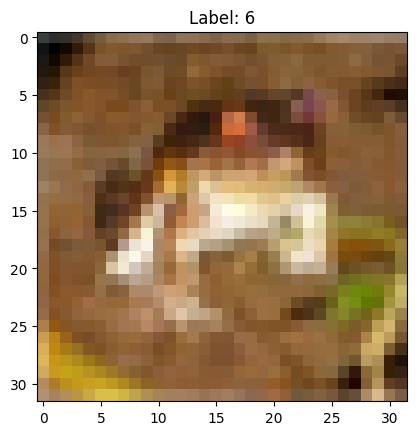

In [4]:
import matplotlib.pyplot as plt

# Show first image
plt.imshow(X[0])
plt.title(f"Label: {Y[0]}")
plt.show()


In [5]:
import numpy as np

X_train, Y_train = [], []

for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X = batch[b'data']
    Y = batch[b'labels']

    X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    X_train.append(X)
    Y_train.extend(Y)

X_train = np.concatenate(X_train)
Y_train = np.array(Y_train)

# Load test set
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
Y_test = np.array(test_batch[b'labels'])

print("Training set:", X_train.shape, Y_train.shape)
print("Test set:", X_test.shape, Y_test.shape)


Training set: (50000, 32, 32, 3) (50000,)
Test set: (10000, 32, 32, 3) (10000,)


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Define transformations (augmentation + normalization)
transform_train = transforms.Compose([
    transforms.ToPILImage(),                # convert numpy → PIL
    transforms.RandomCrop(32, padding=4),   # data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                  # convert PIL → tensor [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Custom Dataset for CIFAR-10
class CIFARDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

# Create datasets
train_dataset = CIFARDataset(X_train, Y_train, transform=transform_train)
test_dataset = CIFARDataset(X_test, Y_test, transform=transform_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Check one batch
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)  # (128, 3, 32, 32)
print("Labels:", labels[:10])


Batch shape: torch.Size([128, 3, 32, 32])
Labels: tensor([7, 7, 4, 5, 4, 6, 4, 0, 0, 6])
